# libraries

In [2]:
# Import necessary libraries

 # For interacting with the operating system
import os 

# For numerical operations on arrays
import numpy as np  

# For image processing
import cv2  

 # For generating random numbers
import random 

# For plotting and visualization
import matplotlib.pyplot as plt  


# Import specific functionalities from TensorFlow and Scikit-learn

 # For deep learning
import tensorflow as tf 

# For data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# For converting labels to one-hot encoding
from tensorflow.keras.utils import to_categorical  

# For building and loading models
from tensorflow.keras.models import Sequential, load_model  

# For splitting data into training and validation sets
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For building layers of the neural network
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  


In [3]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("dheerajperumandla/drowsiness-dataset")

# print("Path to dataset files:", path) 

# Load Dataset

In [4]:
# Initialize lists to hold images and their corresponding labels
images = []
labels = []

# Loop through each label directory
for index, label in enumerate(['Closed', 'Open', 'no_yawn', 'yawn']):  # Assign numeric labels: 0, 1, 2, 3
    
    train_path = 'D:\\projects\\DeepLearning PY Project\\train'
    
    images_folder_path = os.path.join(train_path, label)  # Construct the path to the image folder for the current label

    # Loop through all images in the current label directory
    for image_number in os.listdir(images_folder_path):
        # Construct the full path to the image
        image_path = os.path.join(images_folder_path, image_number)
        
        # Read the image using matplotlib
        image = plt.imread(image_path)
        
        # Resize the image to (150, 150) using OpenCV
        resized_image = cv2.resize(image, (150, 150))
        
        # Convert the image to grayscale
        image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY) 
        
        # Append the processed image and its label to the respective lists
        images.append(image)
        labels.append(index) # numeric labels

# Convert the lists of images and labels to NumPy arrays for efficient numerical operations
images = np.array(images)
labels = np.array(labels)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (2900, 150, 150)
Labels shape: (2900,)


# Split Data

In [5]:
# Ensure the images have an additional channel dimension for compatibility with CNNs
images = np.expand_dims(images, axis=-1)

# Split the data into training and temporary sets (60% training, 40% temporary)
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, 
                                                    shuffle=True, random_state=42)

# Split the temporary set into validation and test sets (20% each from the original data)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, 
                                                shuffle=True, random_state=42)

# Convert the labels to one-hot encoded format for the neural network
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Print the shapes of the training, validation, and test sets
print(f'Train set: {x_train.shape}, {y_train.shape}') 
print(f'Validation set: {x_val.shape}, {y_val.shape}')
print(f'Test set: {x_test.shape}, {y_test.shape}')


Train set: (1740, 150, 150, 1), (1740, 4)
Validation set: (580, 150, 150, 1), (580, 4)
Test set: (580, 150, 150, 1), (580, 4)


# Data Augmentation

In [6]:
# Import the necessary library for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define custom contrast adjustment function
def random_contrast(image, lower=0.9, upper=1.1):
    return tf.image.random_contrast(image, lower=lower, upper=upper)

# Define custom preprocessing function
def custom_preprocess(image):
    image = random_contrast(image)
    return image

# Define ImageDataGenerators for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    preprocessing_function=custom_preprocess
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values for validation and test data to the range [0, 1]

# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)  # Generate batches of tensor image data for training
val_generator = val_test_datagen.flow(x_val, y_val, batch_size=32)  # Generate batches of tensor image data for validation
test_generator = val_test_datagen.flow(x_test, y_test, batch_size=32)  # Generate batches of tensor image data for testing


# Model

In [7]:
# Determine the input shape for the CNN based on the shape of the images
input_shape = images.shape[1:] 
print("Input shape:", input_shape)

# Define a function to create the CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # First convolutional layer
        MaxPooling2D(pool_size=(2, 2)),  # First max pooling layer
        Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
        MaxPooling2D(pool_size=(2, 2)),  # Second max pooling layer
        Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer
        MaxPooling2D(pool_size=(2, 2)),  # Third max pooling layer
        Flatten(),  # Flatten the feature map to a 1D vector
        Dense(256, activation='relu'),  # Fully connected layer with 256 units
        Dropout(0.5),  # Dropout layer to prevent overfitting
        Dense(4, activation='softmax')  # Output layer with 4 units (one for each class)
    ])
    return model

# Create the CNN model using the defined function
model = create_model()

# Compile the model with Adam optimizer, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Input shape: (150, 150, 1)


C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Train The Model

In [8]:
# Train the model using the training and validation data generators
history = model.fit(
    train_generator,  # Generator for training data
    epochs=50,  # Number of epochs to train the model
    validation_data=val_generator  # Generator for validation data
)


C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 551ms/step - accuracy: 0.4061 - loss: 1.2008 - val_accuracy: 0.6966 - val_loss: 0.5356
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 532ms/step - accuracy: 0.7395 - loss: 0.5177 - val_accuracy: 0.7397 - val_loss: 0.4386
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 501ms/step - accuracy: 0.7638 - loss: 0.4371 - val_accuracy: 0.7759 - val_loss: 0.4026
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 546ms/step - accuracy: 0.7758 - loss: 0.4187 - val_accuracy: 0.7914 - val_loss: 0.3791
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 479ms/step - accuracy: 0.8111 - loss: 0.3688 - val_accuracy: 0.7621 - val_loss: 0.3816
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 532ms/step - accuracy: 0.8383 - loss: 0.3383 - val_accuracy: 0.8086 - val_loss: 0.3531
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 507ms/step - accuracy: 0.8104 - loss: 0.3759 - val_accuracy: 0.8069 - val_loss: 0.3557
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 517ms/step - accuracy: 0.8385 - loss: 0.3371 - val_accu

# Test the model

In [9]:
# Evaluate the model using the test data generator
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9483 - loss: 0.1372 
Test Loss: 0.2034529745578766
Test Accuracy: 0.9413793087005615


# Visualize training & validation accuracy and Loss Values

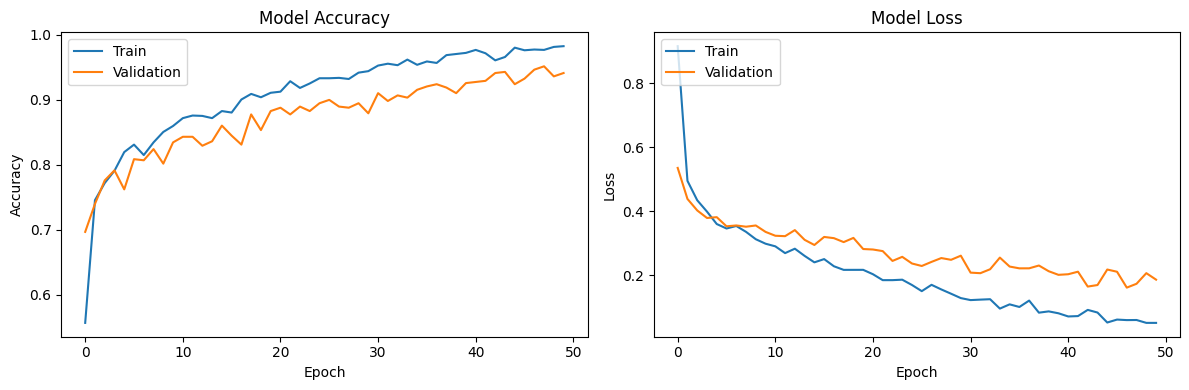

In [10]:
# Import the necessary library for plotting
import matplotlib.pyplot as plt

# Create a figure with a specific size
plt.figure(figsize=(12, 4))

# Plot training and validation accuracy values
plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st plot)
plt.plot(history.history['accuracy'])  # Plot training accuracy
plt.plot(history.history['val_accuracy'])  # Plot validation accuracy
plt.title('Model Accuracy')  # Set the title of the plot
plt.xlabel('Epoch')  # Set the x-axis label
plt.ylabel('Accuracy')  # Set the y-axis label
plt.legend(['Train', 'Validation'], loc='upper left')  # Add a legend to differentiate training and validation accuracy

# Plot training and validation loss values
plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd plot)
plt.plot(history.history['loss'])  # Plot training loss
plt.plot(history.history['val_loss'])  # Plot validation loss
plt.title('Model Loss')  # Set the title of the plot
plt.xlabel('Epoch')  # Set the x-axis label
plt.ylabel('Loss')  # Set the y-axis label
plt.legend(['Train', 'Validation'], loc='upper left')  # Add a legend to differentiate training and validation loss

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


# Some Examples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


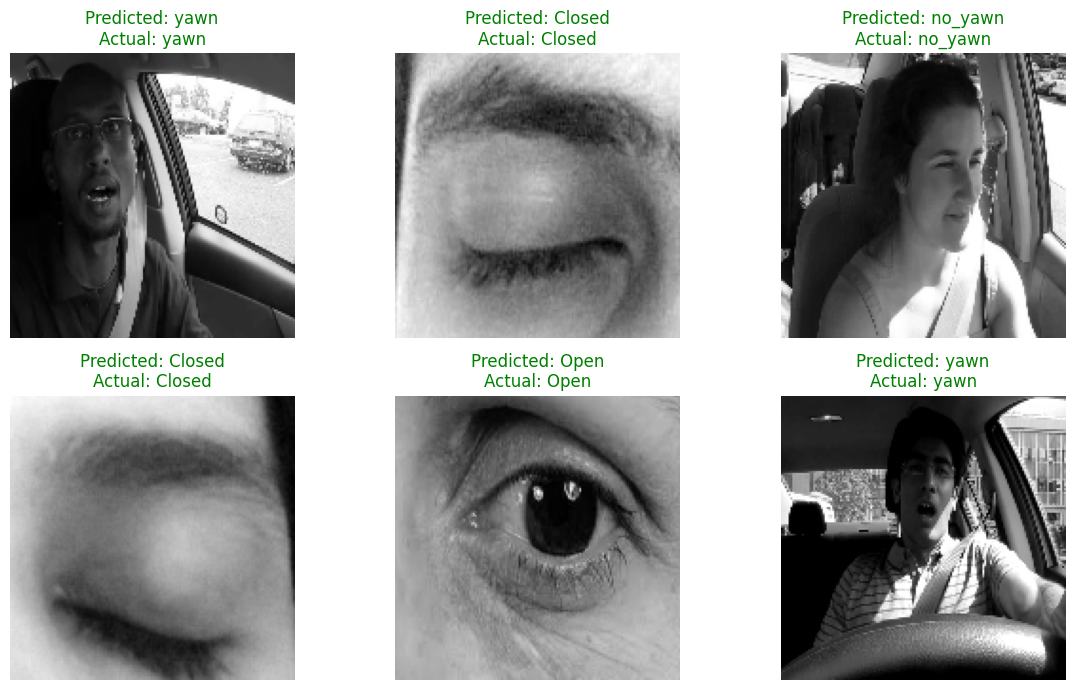

In [11]:
# Define the class labels dictionary
classes = {
    0: "Closed",
    1: "Open",
    2: "no_yawn",
    3: "yawn"
}

# Generate a list of 6 random indices from the training set
random_indices = random.sample(range(len(x_train)), 6)

# Function to load a random sample of images based on indices
def load_random_samples(images, indices):
    selected_images = [images[idx] for idx in indices]
    return np.array(selected_images)

# Load a random sample of images from the training set
random_samples = load_random_samples(x_train, random_indices)

# Predict the classes for the random sample
predictions = model.predict(random_samples)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded actual labels to class indices
actual_labels = np.argmax(y_train[random_indices], axis=1)

# Create a 2x3 subplot for displaying the images and predictions
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axs = axes.ravel()

# Plot each image and its prediction
for i in range(6):
    img = random_samples[i]
    prediction = predicted_classes[i]
    actual_label = actual_labels[i]

    # Display the image in grayscale
    axs[i].imshow(img.squeeze(), cmap='gray')

    # Determine the color of the title (green for correct, red for incorrect)
    col = 'green' if actual_label == prediction else 'red'
    # Set the title with the predicted and actual labels
    axs[i].set_title(f'Predicted: {classes[prediction]}\nActual: {classes[actual_label]}', color=col)
    # Remove the axis for a cleaner look
    axs[i].axis('off')

# Adjust the layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()


# try model in random image 

In [ ]:
# Define the class labels dictionary
classes = {
    0: "Clo sed",
    1: "Open",
    2: "no_yawn",
    3: "yawn"
}

# Path to the image you want to predict
image_path = 'D:\\projects\\DeepLearning PY Project\\train\\Closed\\_1.jpg'

# Read the image using matplotlib
image = plt.imread(image_path)

# Resize the image to (150,150) using OpenCV
resized_image = cv2.resize(image, (150, 150))

# Convert the image to grayscale
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

# Add a channel dimension to the image
gray_image = np.expand_dims(gray_image, axis=-1)

# Add a batch dimension to the image
gray_image = np.expand_dims(gray_image, axis=0)

# Predict the class of the image
predictions = model.predict(gray_image)

# Convert predicted probabilities to class index
predicted_class = np.argmax(predictions, axis=1)[0]

# Retrieve the class label from the dictionary
predicted_label = classes[predicted_class]

print(f"Actual Class Closed")
print(f"Predicted Class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Actual Class Closed
Predicted Class: Closed


# save model

In [13]:
import pickle
import tensorflow as tf

# # Assuming 'model' is your trained TensorFlow model
# model.save('DDD-model.pkl')

model.save("DDD_model2.h5")
print("Model saved as DDD_model2.h5")

Model saved as DDD_model2.h5


# End